# 서울시의 평균기온 예측
서울시의 일자별 기상 데이터 분석을 통해 평균기온을 예측하는 AI 모델 개발

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/train.csv")
data

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6
...,...,...,...,...,...,...,...,...,...,...,...
23006,2022-12-27,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
23007,2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
23008,2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
23009,2022-12-30,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8


In [ ]:
# 날짜 데이터 전처리
date_time = pd.to_datetime(data.pop('일시'), format='%Y-%m-%d')
data

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6
...,...,...,...,...,...,...,...,...,...,...
23006,3.3,-7.3,10.6,NaN,69.8,1.8,8.8,10.25,91.7,-2.6
23007,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.86,90.6,-3.3
23008,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.88,93.8,-2.9
23009,2.3,-4.4,6.7,0.0,65.6,1.9,7.9,10.84,82.3,-1.8


## 결측치

In [ ]:
# 결측치
data.isnull().sum()

최고기온        3
최저기온        3
일교차         4
강수량     13861
평균습도        0
평균풍속        4
일조합       118
일사합      4862
일조율       366
평균기온        0
dtype: int64

- 최고기온, 최저기온, 일교차, 평균풍속 -> 제거
- 강수량 0으로 대체
- 일조합, 일사합, 일조율 평균값으로 대체

In [ ]:
data = data.dropna(subset=['최고기온', '최저기온', '일교차', '평균풍속'])

In [ ]:
data.loc[data['강수량'].isnull(), '강수량'] = 0.0

<ipython-input-83-c1c31305d9f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[data['강수량'].isnull(), '강수량'] = 0.0


In [ ]:
cols = ['일조합', '일사합', '일조율']

for col in cols:
  data[col].fillna(data[col].mean(), inplace=True)

<ipython-input-84-2e16c8f5c021>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col].fillna(data[col].mean(), inplace=True)


In [ ]:
data.isnull().sum()

최고기온    0
최저기온    0
일교차     0
강수량     0
평균습도    0
평균풍속    0
일조합     0
일사합     0
일조율     0
평균기온    0
dtype: int64

In [ ]:
X = data.drop('평균기온', axis=1)
y = data['평균기온']

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape[1]

9

In [ ]:
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
461/461 [==============================] - 4s 5ms/step - loss: 112.2184 - mae: 8.2134 - val_loss: 10.1611 - val_mae: 2.4617
Epoch 2/50
461/461 [==============================] - 1s 3ms/step - loss: 3.6233 - mae: 1.3899 - val_loss: 1.3368 - val_mae: 0.8607
Epoch 3/50
461/461 [==============================] - 1s 3ms/step - loss: 0.8190 - mae: 0.6621 - val_loss: 0.4482 - val_mae: 0.5010
Epoch 4/50
461/461 [==============================] - 1s 3ms/step - loss: 0.3897 - mae: 0.4651 - val_loss: 0.2921 - val_mae: 0.4076
Epoch 5/50
461/461 [==============================] - 1s 2ms/step - loss: 0.3085 - mae: 0.4184 - val_loss: 0.2968 - val_mae: 0.4172
Epoch 6/50
461/461 [==============================] - 1s 3ms/step - loss: 0.2914 - mae: 0.4086 - val_loss: 0.2597 - val_mae: 0.3869
Epoch 7/50
461/461 [==============================] - 1s 3ms/step - loss: 0.2903 - mae: 0.4093 - val_loss: 0.2526 - val_mae: 0.3835
Epoch 8/50
461/461 [==============================] - 1s 3ms/step - loss:

In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

# Predictions
y_pred = model.predict(X_test).flatten()

print(f'Mean Squared Error (MSE): {loss}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

144/144 [==============================] - 0s 2ms/step
Mean Squared Error (MSE): 0.28614526987075806
Mean Absolute Error (MAE): 0.40828120708465576
Root Mean Squared Error (RMSE): 0.534925523753635


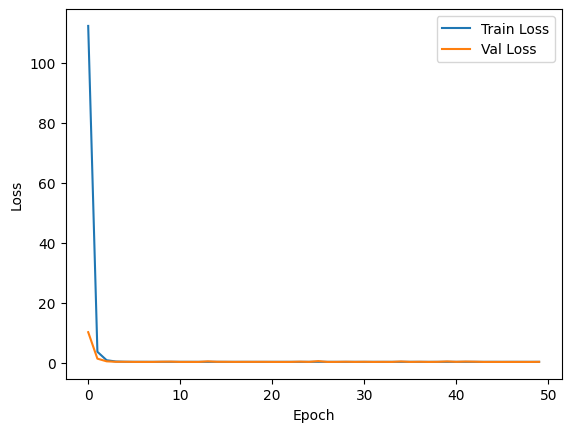

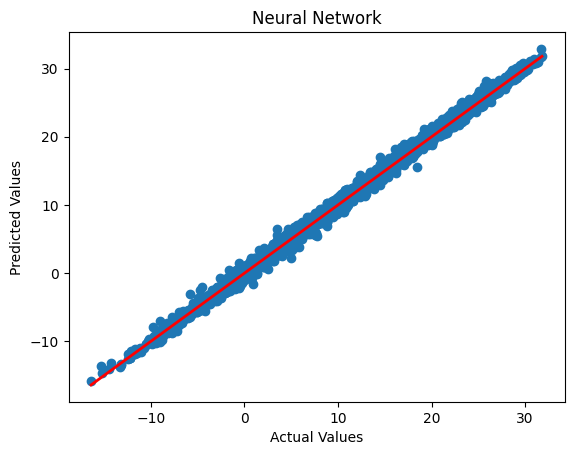

In [ ]:
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch

  plt.figure(1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],label='Val Loss')
  plt.legend()

  plt.show()
  plt.figure(2)
  plt.scatter(y_test, y_pred)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Neural Network')
  plt.show()


plot_history(history)

Layer 변경

In [ ]:
# MLP
model = Sequential()
model.add(Dense(16, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history_2 = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
461/461 [==============================] - 2s 3ms/step - loss: 181.6294 - mae: 10.9833 - val_loss: 33.0749 - val_mae: 4.9884
Epoch 2/50
461/461 [==============================] - 2s 4ms/step - loss: 7.7983 - mae: 2.0607 - val_loss: 1.8262 - val_mae: 1.0530
Epoch 3/50
461/461 [==============================] - 2s 4ms/step - loss: 1.2906 - mae: 0.8609 - val_loss: 0.7222 - val_mae: 0.6506
Epoch 4/50
461/461 [==============================] - 2s 3ms/step - loss: 0.5194 - mae: 0.5371 - val_loss: 0.3643 - val_mae: 0.4536
Epoch 5/50
461/461 [==============================] - 1s 2ms/step - loss: 0.3384 - mae: 0.4317 - val_loss: 0.2900 - val_mae: 0.4036
Epoch 6/50
461/461 [==============================] - 1s 2ms/step - loss: 0.2945 - mae: 0.4057 - val_loss: 0.2784 - val_mae: 0.3992
Epoch 7/50
461/461 [==============================] - 1s 3ms/step - loss: 0.2804 - mae: 0.3986 - val_loss: 0.2509 - val_mae: 0.3783
Epoch 8/50
461/461 [==============================] - 1s 2ms/step - loss

In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

144/144 [==============================] - 0s 2ms/step


In [ ]:
y_pred = model.predict(X_test).flatten()

print(f'Mean Squared Error (MSE): {loss}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

144/144 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 0.2437039464712143
Mean Absolute Error (MAE): 0.3713875710964203
Root Mean Squared Error (RMSE): 0.49366380778805863


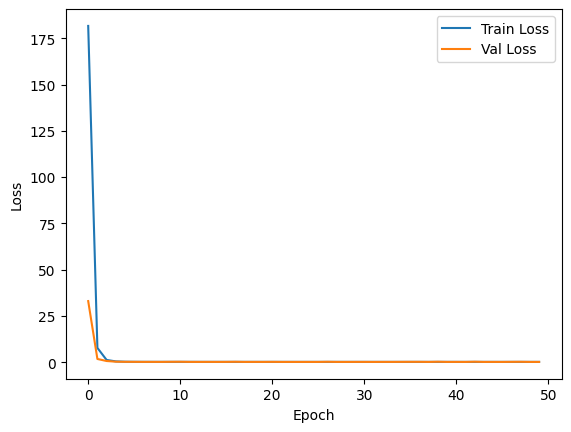

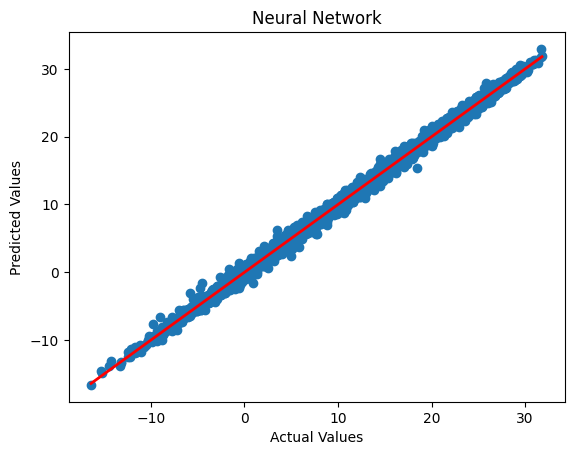

In [ ]:
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epoch']=history.epoch

  plt.figure(1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],label='Val Loss')
  plt.legend()
  plt.show()

  plt.figure(2)
  plt.scatter(y_test, y_pred)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('Neural Network')
  plt.show()


plot_history(history_2)

In [ ]:
y_pred

array([13.4235115, 24.276535 ,  1.5749118, ..., -4.2472606,  2.2662122,
        7.5220666], dtype=float32)

In [ ]:
y_test

14908    14.3
3471     24.8
16819     1.3
7662     -1.3
12066    -0.7
         ... 
5603     10.3
16864     3.6
10257    -4.0
12840     1.8
20495     8.1
Name: 평균기온, Length: 4601, dtype: float64

In [ ]:
y_pred_ = np.array(y_pred[0:100])
y_test_ = np.array(y_test[0:100])

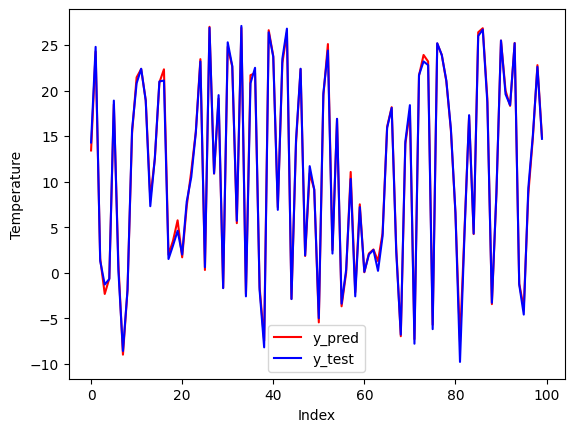

In [ ]:
plt.plot(y_pred_, color='red', label='y_pred')
plt.plot(y_test_, color='blue', label='y_test')
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.legend()
plt.show()